In [1]:
import torch
import numpy as np
import scipy.stats as stats
from scipy.stats import multivariate_normal, norm, bernoulli
import matplotlib.pyplot as plt

In [2]:
from gibbsibp import UncollapsedGibbsIBP, normalise_bern_logpostprop

In [3]:
F_np = np.array(
    [[0.51, -0.01],
     [0.49, 0.01],
     [0.01, 0.5]]
    )
X_np = np.array(
    [[0.0, 1.0],
     [0.0, 1.0],
     [1.0, 0.0]]
    )

A_np = np.array(
    [[0.4, 0.1],
     [0.1, 0.4]]
    )
Y_np = np.array(
    [[0.0, 1.0],
     [1.0, 0.0]]
    )
Z_np = np.array(
    [[1.0, 0.0],
     [1.0, 0.0],
     [0.0, 1.0]]
    )

SIGMA2_N = 0.05
SIGMA2_A = 1.0
LAMBD = 0.75
EPSILON = 0.25
N=3
K=2
D=2
T=2

F = torch.tensor(F_np, dtype=torch.float32)
X = torch.tensor(X_np, dtype=torch.float32)
A = torch.tensor(A_np, dtype=torch.float32)
Y = torch.tensor(Y_np, dtype=torch.float32)
Z = torch.tensor(Z_np, dtype=torch.float32)

inf = UncollapsedGibbsIBP(K=1, max_K=6, alpha=0.01, sigma2_a=SIGMA2_A, phi=0.25, sigma2_n=SIGMA2_N, epsilon=EPSILON, lambd=LAMBD)

As, Zs, Ys = inf.gibbs(F, X, 0)

### Test of Gaussian log-likelihood $P(F|A,Z)$
Tests the method `loglik_f_i__given_Az`, and also `loglik_f_i__given_Az_Knew` with `k_new=0`

In [4]:
for i in range(F.shape[0]):
    # Calculate log likelihood using loglik_f_i__given_Az
    my_loglik_1 = inf.loglik_f_i__given_Az(F[i:i+1,:], A, Z[i:i+1,:]).numpy()[0]
    # Calculate log likelihood using loglik_f_i__given_Az_Knew
    my_loglik_2 = inf.loglik_f_i__given_Az_Knew(F[i:i+1,:], A, Z[i:i+1,:], k_new=0).numpy()[0]

    # Compare results with the log likelihood calculated in scipy
    mean = (Z[i:i+1]@A).numpy()[0]
    cov = np.eye(D)*SIGMA2_N
    sp_loglik = multivariate_normal.logpdf(F_np[i,:], mean, cov)

    if \
        np.isclose(my_loglik_1, sp_loglik, atol=1e-6) and \
        np.isclose(my_loglik_2, sp_loglik, atol=1e-6) and \
        np.isclose(my_loglik_1, my_loglik_2, atol=1e-6):
        print(f"Test passed for sample {i}")


Test passed for sample 0
Test passed for sample 1
Test passed for sample 2


### PIT test for Gaussian posterior $P(A|F,Z)$
Tests the method `resample_A`

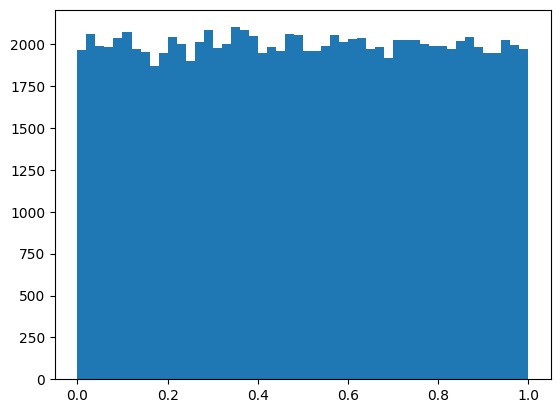

KstestResult(statistic=np.float64(0.00240841526531127), pvalue=np.float64(0.6067822323369965), statistic_location=np.float64(0.26849841526531126), statistic_sign=np.int8(-1))


In [5]:
SIGMA2_N = 0.2
SIGMA2_A = 0.4
inf = UncollapsedGibbsIBP(K=K, max_K=6, alpha=0.01, sigma2_a=SIGMA2_A, phi=0.25, sigma2_n=SIGMA2_N, epsilon=0.25, lambd=0.75)

res = []
for i in range(100000):
    # Sample from the prior
    A_true = inf.sample_A_prior(K, D)
    # Sample from the likelihood
    F_obs = inf.F_likelihood_sample(Z, A_true)

    # Calculate parameters of the posterior
    mu, cov = inf.posterior_param_A(F_obs, Z)

    # get a single element
    mean = mu[0,0].numpy()
    std  = torch.sqrt(cov[0,0]).numpy()
    
    # perform PIT by evaluating the CDF of the posterior at true value of the parameter
    res.append(norm.cdf(A_true.numpy()[0,0], mean, std))

res = np.array(res)
plt.hist(res, bins=50)
plt.show()
print(stats.kstest(res, 'uniform'))

### Test of bernoulli likelihood $P(X|Y,Z)$
Tests the method `loglik_x_i__given_Yz`, and also `loglik_x_i__given_Yz_Knew` with `k_new=0`

In [6]:

for i in range(X.shape[0]):
    # Calculate log likelihood using loglik_x_i__given_Yz
    my_loglik_1 = inf.loglik_x_i__given_Yz(X[i:i+1,:], Y, Z[i:i+1,:]).numpy()

    # Calculate log likelihood using loglik_x_i__given_Yz_Knew
    my_loglik_2 = inf.loglik_x_i__given_Yz_Knew(X[i:i+1,:], Y, Z[i:i+1,:], k_new=0).numpy()

    # Calculate the log likelihood under the Bernoulli distribution in scipy
    n_actfeat = torch.matmul(Z[i:i+1,:], Y)
    p = 1 - ((((1 - LAMBD)**n_actfeat))*(1 - EPSILON)) # probability of observing 1
    
    sp_loglik = 0
    for k in range(X.shape[1]):
        sp_loglik += bernoulli.logpmf(X_np[i,k], p[0,k])

    # Compare results with the log likelihood calculated in scipy
    if \
        np.isclose(my_loglik_1, sp_loglik, atol=1e-6) and \
        np.isclose(my_loglik_2, sp_loglik, atol=1e-6) and \
        np.isclose(my_loglik_1, my_loglik_2, atol=1e-6):
        print(f"Test passed for sample {i}")

Test passed for sample 0
Test passed for sample 1
Test passed for sample 2


### RPIT Test of bernoulli posterior $P(Y|X,Z)$

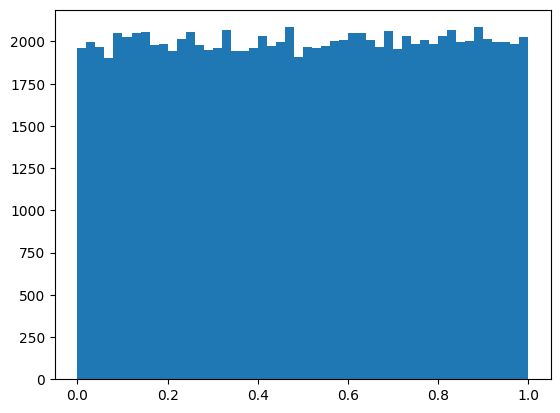

KstestResult(statistic=np.float64(0.0034941764068603387), pvalue=np.float64(0.17348028902861645), statistic_location=np.float32(0.5717242), statistic_sign=np.int8(-1))


In [7]:
LAMBD = 0.8
EPSILON = 0.2
PHI = 0.25
inf = UncollapsedGibbsIBP(K=2, max_K=6, alpha=0.01, sigma2_a=SIGMA2_A, phi=PHI, sigma2_n=SIGMA2_N, epsilon=EPSILON, lambd=LAMBD)
As, Zs, Ys = inf.gibbs(F, X, 0)

res = []
for i in range(100000):
    # Sample from the prior
    Y_true = inf.sample_Y_prior(K, T)
    
    # Sample from the likelihood
    X_obs = inf.X_likelihood_sample(Z, Y_true)

    # Calculate parameters of the posterior
    Y_curr = inf.sample_Y_prior(K, T) # Start with a random sample of Y
    
    pYkt_1_arr = torch.zeros((K, T))
    for k in range(K):
        for t in range(T):
            pYkt_1_arr[k, t] = inf.posterior_param_Y_kt(Z, X_obs, Y_curr, k, t) # Calculate the posterior for each element of Y

    # perform !!Randomised!! PIT
    u = stats.uniform.rvs()
    if Y_true[0,0] == 0:
        u = u * (1 - pYkt_1_arr[0,0])
    else:
        u = (1-pYkt_1_arr[0,0]) + u*pYkt_1_arr[0,0]
    res.append(u)

res = np.array(res)
plt.hist(res, bins=50)
plt.show()
print(stats.kstest(res, 'uniform'))

### TODO: Numerical validation of analytical formulas integrating out $A_{new}$ (Eq.13) and $Y_{new}$ (Eq.12) when sampling $K_{new}$ (Eq. 10).

### TODO: 